Dear Mr. Greg,

I apologize for the issue with the code. It seems that my dataset only contains 104 rows, which is quite small for training a deep learning model effectively. This may be affecting the model's performance. I realized a little too late while working on the functional model. At first, I didn’t suspect anything during the EDA process.


Thus, I sincerely apologize for not being careful in selecting the dataset. Although the model doesn’t produce good results, I have provided explanations for every part of my code. I hope this can make up for my poor decision-making.


Thank you.

In [2]:
!pip install keras-tuner # untuk melakukan gridsearch untuk deep learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.5 MB/s eta 0:00:00


In [3]:
import keras_tuner as kt
import pandas as pd
import numpy as np
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Dense, Concatenate, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder

SEED_VALUE=123
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [4]:
print('num Device: ',len(tf.config.experimental.list_physical_devices()))
print(tf.config.experimental.list_physical_devices())

num Device:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
df = pd.read_csv('possum.csv')
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


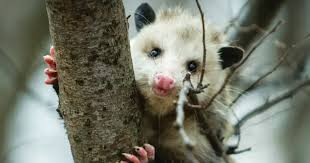


**variable in a nutshell:**
1. case = observation number
2. site = The site number where the possum was trapped.
3. sex = Gender, either m (male) or f (female).
4. age = Age of possum
5. hdlngth = Head length, in mm.
6. skullw = Skull width, in mm.
7. totlngth = Total length, in cm.
8. taill = Tail length, in cm.
9. footlgth = foot length
10. earconch = ear conch length
11. eye = distance from medial canthus to lateral canthus of right eye
12. chest = chest girth (in cm)
13. belly = belly girth (in cm)
14. Pop = Population, either Vic (Victoria) or other (New South Wales or Queensland).

# EDA

**checking for:**
* incorrect/inconsistent data types
* missing value
* duplicate
* distribution

In [6]:
df.shape

(104, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   Pop       104 non-null    object 
 3   sex       104 non-null    object 
 4   age       102 non-null    float64
 5   hdlngth   104 non-null    float64
 6   skullw    104 non-null    float64
 7   totlngth  104 non-null    float64
 8   taill     104 non-null    float64
 9   footlgth  103 non-null    float64
 10  earconch  104 non-null    float64
 11  eye       104 non-null    float64
 12  chest     104 non-null    float64
 13  belly     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


In [8]:
# i will drop 'case' variable because it has not meaningful meaning (index)
df = df.drop(labels=['case'], axis=1)

In [9]:
# 'site' here supposed to be categorical
# df['site'] = df['site'].astype('str')
# but i wont convert it because it will cause trouble in building tensor dataset

In [10]:
# because the data only contain 2 categorical variable, i wont be using the unique function that've been provided
df['Pop'].unique()

array(['Vic', 'other'], dtype=object)

In [11]:
df['sex'].unique()

array(['m', 'f'], dtype=object)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   site      104 non-null    int64  
 1   Pop       104 non-null    object 
 2   sex       104 non-null    object 
 3   age       102 non-null    float64
 4   hdlngth   104 non-null    float64
 5   skullw    104 non-null    float64
 6   totlngth  104 non-null    float64
 7   taill     104 non-null    float64
 8   footlgth  103 non-null    float64
 9   earconch  104 non-null    float64
 10  eye       104 non-null    float64
 11  chest     104 non-null    float64
 12  belly     104 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 10.7+ KB


In [13]:
df.duplicated().sum() # no duplicated value as well

0

In [14]:
df.isna().sum() # data got 0 missing value

,0
site,0
Pop,0
sex,0
age,2
hdlngth,0
skullw,0
totlngth,0
taill,0
footlgth,1
earconch,0


In [15]:
# see basic statistical analysis for numerical variable
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,site,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,104.000000,102.000000,104.000000,104.000000,104.000000,104.000000,103.000000,104.000000,104.000000,104.000000,104.000000
mean,3.625000,3.833333,92.602885,56.883654,87.088462,37.009615,68.459223,48.130769,15.046154,27.000000,32.586538
std,2.349086,1.909244,3.573349,3.113426,4.310549,1.959518,4.395306,4.109380,1.050374,2.045597,2.761949
min,1.000000,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,40.300000,12.800000,22.000000,25.000000
25%,1.000000,2.250000,90.675000,54.975000,84.000000,35.875000,64.600000,44.800000,14.400000,25.500000,31.000000
50%,3.000000,3.000000,92.800000,56.350000,88.000000,37.000000,68.000000,46.800000,14.900000,27.000000,32.500000
75%,6.000000,5.000000,94.725000,58.100000,90.000000,38.000000,72.500000,52.000000,15.725000,28.000000,34.125000
max,7.000000,9.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.000000,40.000000


***some possum info:***
* the mean age of possums is 3.83 years, with a standard deviation of 1.91
* total body length (excluding tail) averages 87.08 cm, ranging from 75 cm to 96.5 cm
* tail length has a mean of 37 cm, with a variation from 32 cm to 43 cm
* foot length ranges between 60.3 mm to 77.9 mm, with an average of 68.46 mm
* the size variability show there are moderate size diversity, suggesting diff subspecies may grow in diff patterns

<Axes: xlabel='site'>

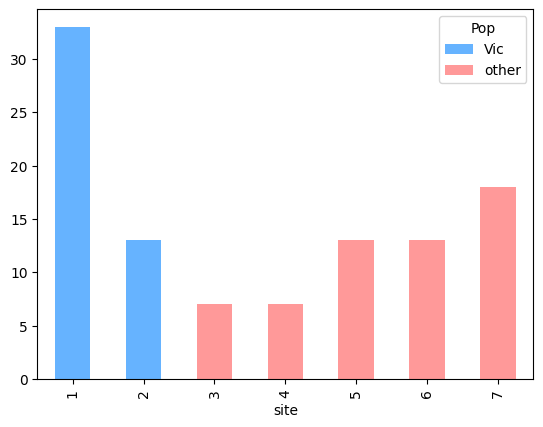

In [16]:
# cat distribution
# bargraph for Pop per site
df.groupby(['site', 'Pop']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=["#66b3ff","#ff9999"]
)

All of the Victoria's possum are kept in site 1 and 2, while New South Wales or Queensland's possum kept in site 3,4,5,6,7

<Axes: ylabel='count'>

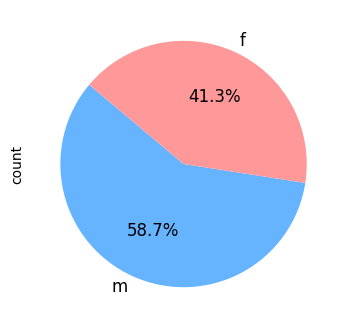

In [17]:
# piechart for sex
plt.figure(figsize=(4, 4))
df["sex"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    colors=["#66b3ff","#ff9999"],
    startangle=140,
    fontsize=12,
)

<Axes: ylabel='count'>

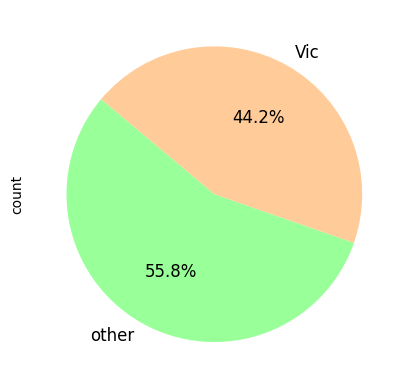

In [18]:
# piechart for Pop
df['Pop'].value_counts().plot(
    kind='pie',
    autopct="%1.1f%%",
    colors=["#99ff99", "#ffcc99"],
    startangle=140,
    fontsize=12,
)

<Axes: xlabel='Pop'>

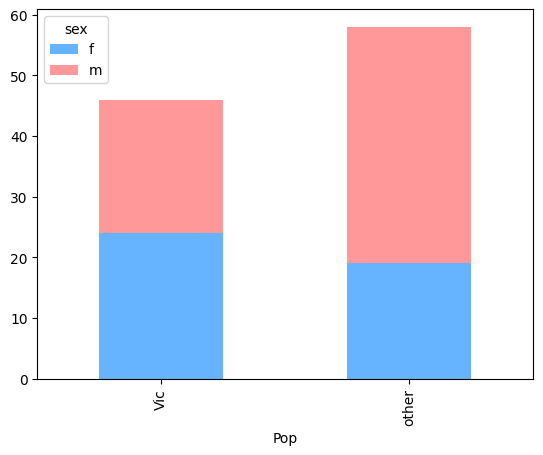

In [19]:
# stack bargraph for distribution of sex per Pop
df.groupby(['Pop', 'sex']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=["#66b3ff","#ff9999"]
)

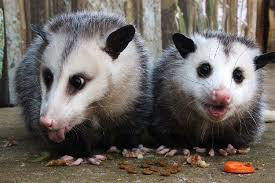

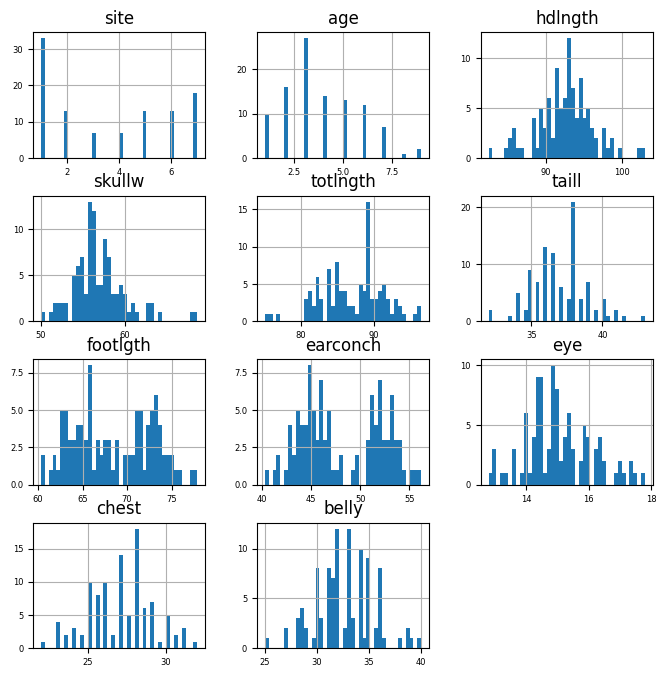

In [20]:
df.hist(figsize=(8, 8), bins=40, xlabelsize=6, ylabelsize=6);

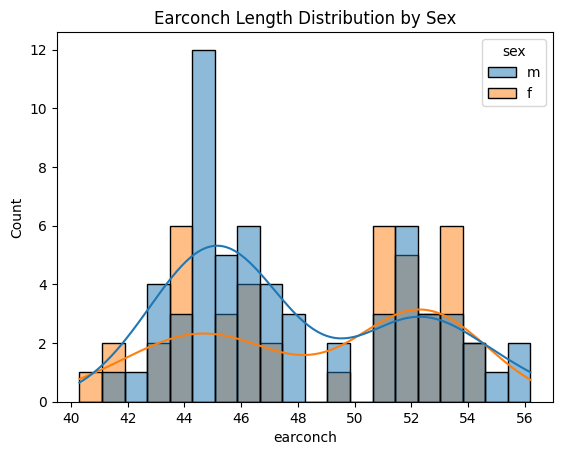

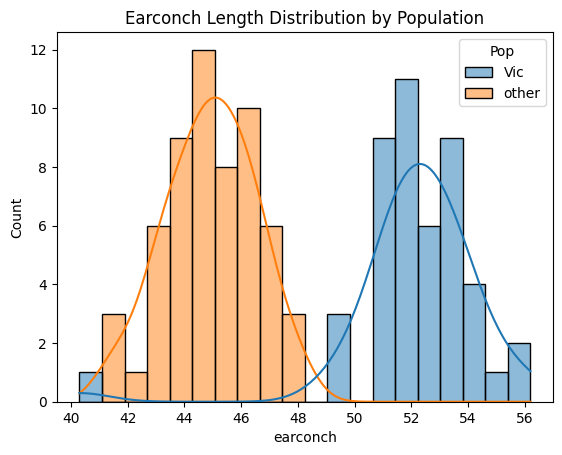

In [21]:
# looking for an answer why 'earconch' got 2 peaks

# because of the sex?
sns.histplot(data=df, x='earconch', hue='sex', kde=True, bins=20)
plt.title("Earconch Length Distribution by Sex")
plt.show()

# or by population?
sns.histplot(data=df, x='earconch', hue='Pop', kde=True, bins=20)
plt.title("Earconch Length Distribution by Population")
plt.show()

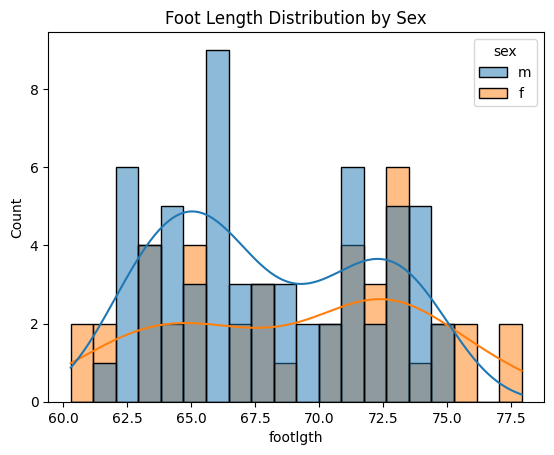

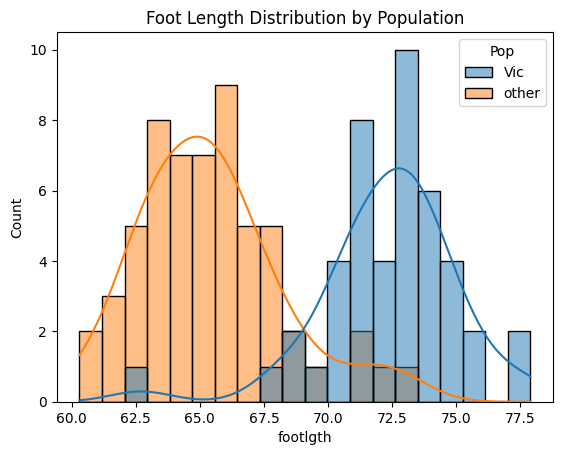

In [22]:
# trying to look whether foot length double peak also due to sex / Pop

# because of the sex?
sns.histplot(data=df, x='footlgth', hue='sex', kde=True, bins=20)
plt.title("Foot Length Distribution by Sex")
plt.show()

# or by population?
sns.histplot(data=df, x='footlgth', hue='Pop', kde=True, bins=20)
plt.title("Foot Length Distribution by Population")
plt.show()

***possum finding???***
* Victorian possum tends to have bigger earconch and longer foot length

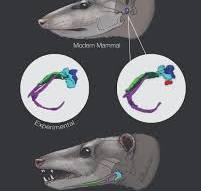

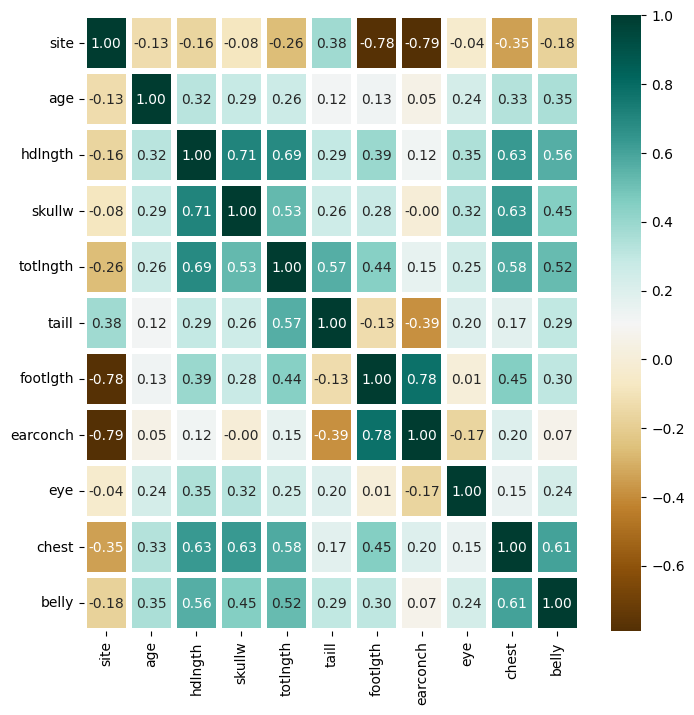

In [23]:
# looking for linearity
corr = df.select_dtypes(include=np.number).corr() # select only numerical attributtes
plt.figure(figsize = (8, 8))
sns.heatmap(corr, linewidths = 4, annot = True, fmt = ".2f", cmap="BrBG")
plt.show()

***more possums finding???***
* longer heads are associated with wider skulls and larger chest sizes
* possums with longer total body length also tend to have larger bellies
* possums with longer tails tend to have shorter feet

In [24]:
df.shape

(104, 13)

# Data Splitting

In [25]:
inputDF = df.drop('Pop', axis=1)
outputDF = df['Pop']

In this dataset we will do classification task to predict whether the possum is Victoria or Other.

In [26]:
#x,y = df.drop(['Pop'],axis=1),df['Pop']

In [27]:
x_train, x_test, y_train, y_test = train_test_split(inputDF, outputDF, test_size = 0.8, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25, random_state = SEED_VALUE)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(15, 12) (15,)
(5, 12) (5,)
(84, 12) (84,)


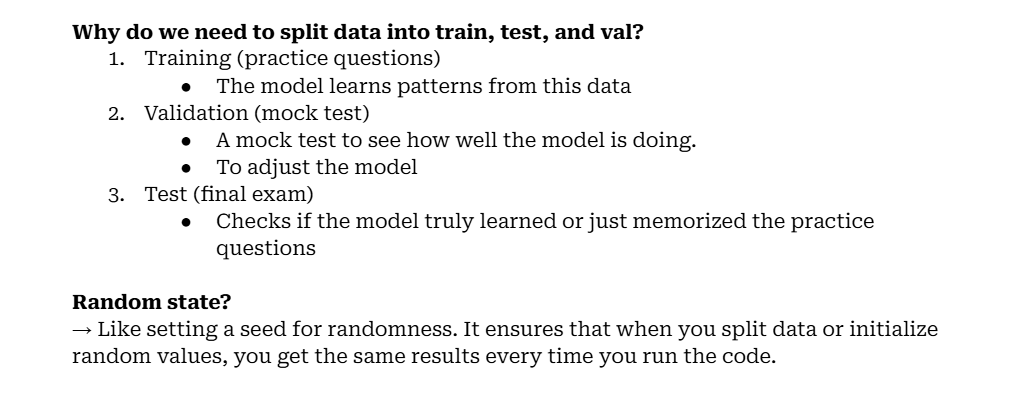

# Encoding

In [28]:
nom_cols = ['sex'] # saving list of variable that neede to encode

In [29]:
# one-hot encoder --> make a new column with 1 0
ohe_encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

# doing the encoding for train, val, and test
new_nom_cols = ohe_encoder.fit_transform(x_train[nom_cols])
encoded_data = pd.DataFrame(new_nom_cols, columns=ohe_encoder.get_feature_names_out(nom_cols))
x_train = x_train.reset_index(drop=True)
x_train = pd.concat([x_train.drop(nom_cols,axis=1,errors='ignore'),encoded_data],axis=1)

new_nom_cols = ohe_encoder.transform(x_val[nom_cols])
encoded_data = pd.DataFrame(new_nom_cols, columns=ohe_encoder.get_feature_names_out(nom_cols))
x_val = x_val.reset_index(drop=True)
x_val = pd.concat([x_val.drop(nom_cols,axis=1,errors='ignore'),encoded_data],axis=1)

new_nom_cols = ohe_encoder.transform(x_test[nom_cols])
encoded_data = pd.DataFrame(new_nom_cols, columns=ohe_encoder.get_feature_names_out(nom_cols))
x_test = x_test.reset_index(drop=True)
x_test = pd.concat([x_test.drop(nom_cols,axis=1,errors='ignore'),encoded_data],axis=1)

In [30]:
x_train.head() # checking to make sure

,site,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,sex_f,sex_m
0,7,3.0,89.2,54.0,82.0,38.0,63.8,44.9,12.8,24.0,31.0,0.0,1.0
1,2,3.0,90.7,55.9,81.0,34.0,71.5,54.0,14.6,27.0,31.5,0.0,1.0
2,1,3.0,96.3,58.5,91.0,39.5,73.5,52.1,16.2,28.0,36.0,0.0,1.0
3,2,7.0,92.4,56.0,80.5,35.5,68.4,49.5,15.9,27.0,30.0,0.0,1.0
4,7,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0,0.0,1.0


In [31]:
# one hot encoder for y ['Pop'] output variable
y_train_encoded = ohe_encoder.fit_transform(y_train.to_frame())  # Convert to DataFrame before encoding
y_train = pd.DataFrame(y_train_encoded, columns=ohe_encoder.get_feature_names_out(['Pop']))

y_val_encoded = ohe_encoder.transform(y_val.to_frame())
y_val = pd.DataFrame(y_val_encoded, columns=ohe_encoder.get_feature_names_out(['Pop']))

y_test_encoded = ohe_encoder.transform(y_test.to_frame())
y_test = pd.DataFrame(y_test_encoded, columns=ohe_encoder.get_feature_names_out(['Pop']))

In [32]:
y_train.head()

,Pop_Vic,Pop_other
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0


# Scaling

In [33]:
num_cols = ['age', 'hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']

In [34]:
scaler = StandardScaler()
x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_val[num_cols] = scaler.transform(x_val[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

In [35]:
# print(x_train.isna().sum())  # Check NaNs in features
# print(y_train.isna().sum())  # Check NaNs in target labels


# Building the Tensor Dataset

In [36]:
# convert data into TensorFlow format
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32).shuffle(buffer_size=len(x_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(32)

In [37]:
train_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 13), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

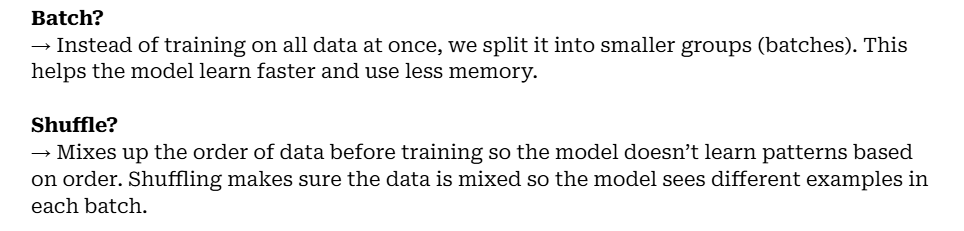

# Sequential

In [38]:
x_train.shape[1] # input size (columns)

13

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model_seq = tf.keras.Sequential([
    Input(shape =(13,)),
    Dense(36, activation='relu'),  # input layer
    Dropout(0.3),
    Dense(8, activation='relu'),  # hidden layer
    Dropout(0.3),
    Dense(2, activation='softmax')  # output layer (for multi-class classification) --> in Pop there are two category (Vic, other)
])

model_seq.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 36)                  │             504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 818 (3.20 KB)

 Trainable params: 818 (3.20 KB)

 Non-trainable params: 0 (0.00 B)

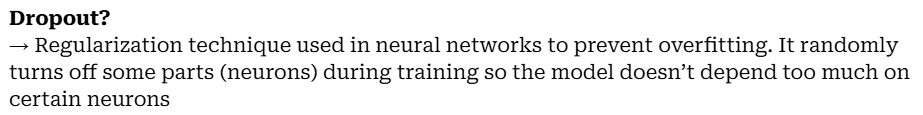

In [40]:
model_seq.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005, clipnorm =1.0),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ["accuracy"]
)

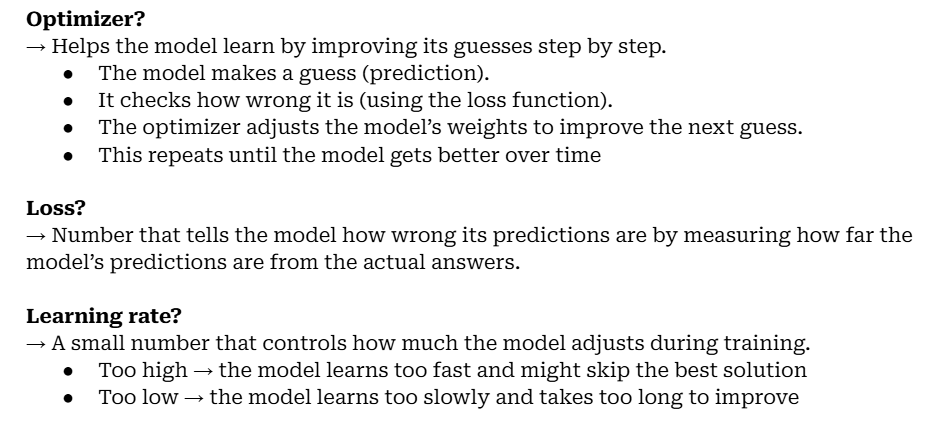

In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

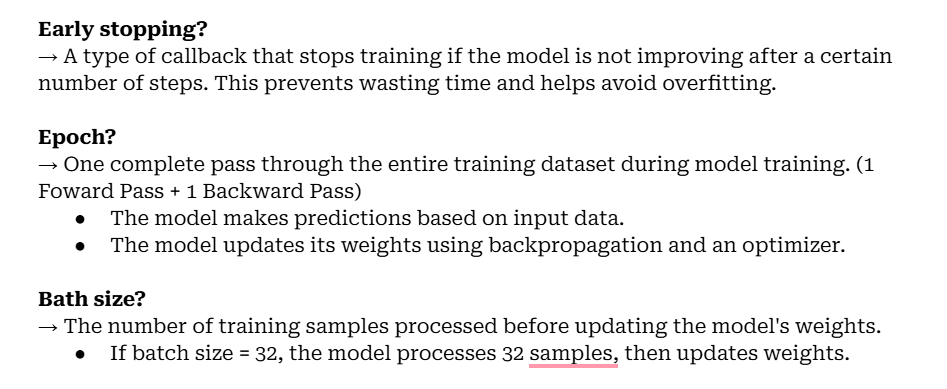

In [42]:
history_seq = model_seq.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    batch_size = 12,
    callbacks=[early_stopping])

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5333 - loss: 0.8592 - val_accuracy: 0.2000 - val_loss: 1.4873
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.2667 - loss: 1.2400 - val_accuracy: 0.2000 - val_loss: 1.4622
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5333 - loss: 1.4914 - val_accuracy: 0.2000 - val_loss: 1.4377
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4000 - loss: 1.4797 - val_accuracy: 0.2000 - val_loss: 1.4117
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4000 - loss: 1.2166 - val_accuracy: 0.2000 - val_loss: 1.3865
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4667 - loss: 1.2404 - val_accuracy: 0.4000 - val_loss: 1.3617
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4000 - loss: 1.2483 - val_accuracy: 0.4000 - val_loss: 1.3370
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5333 - loss: 1.0487 - val_accuracy: 0.4000 - val_loss

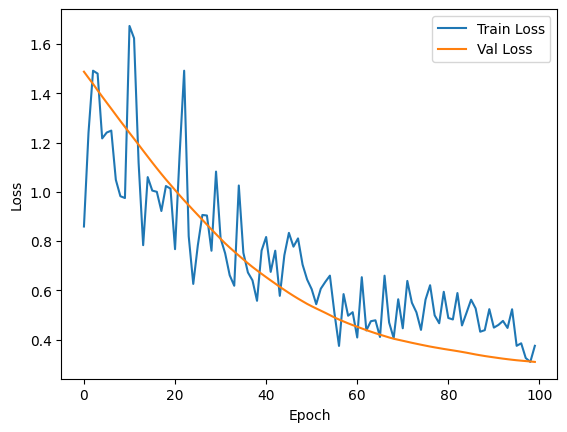

In [43]:
train_loss_seq = history_seq.history['loss']
val_loss_seq = history_seq.history['val_loss']

plt.plot(train_loss_seq,label="Train Loss")
plt.plot(val_loss_seq,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [44]:
# test the model
model_seq.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9172 - loss: nan


[nan, 0.9047619104385376]

1. There are 3 batches in the test dataset.
2. The model achieved 91.72% accuracy on the test dataset.
3. The loss value nan indicating there is an issue.
PS i alr debug eveything and i dont seem to get what cause this problem, sorry.

In [45]:
# predict the class probabilities for the training data
train_result_seq=model_seq.predict(x_train)

# predicts the class probabilities for the test data
test_result_seq=model_seq.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 


In [46]:
# convert predicted probabilities to class labels
y_train_pred = np.argmax(train_result_seq, axis=1)
y_test_pred = np.argmax(test_result_seq, axis=1)

# convert actual labels from one-hot encoding to class labels
y_train_true = np.argmax(y_train.values, axis=1)
y_test_true = np.argmax(y_test.values, axis=1)

In [47]:
from sklearn.metrics import classification_report

# compute metrics for train set
print("Train Set Evaluation:")
print(classification_report(y_train_true, y_train_pred, target_names=['Victoria', 'Other']))
print("\n")
# compute metrics for test set
print("Test Set Evaluation:")
print(classification_report(y_test_true, y_test_pred, target_names=['Victoria', 'Other']))


Train Set Evaluation:
              precision    recall  f1-score   support

    Victoria       1.00      0.83      0.91         6
       Other       0.90      1.00      0.95         9

    accuracy                           0.93        15
   macro avg       0.95      0.92      0.93        15
weighted avg       0.94      0.93      0.93        15



Test Set Evaluation:
              precision    recall  f1-score   support

    Victoria       1.00      0.79      0.89        39
       Other       0.85      1.00      0.92        45

    accuracy                           0.90        84
   macro avg       0.92      0.90      0.90        84
weighted avg       0.92      0.90      0.90        84



Athough there are some problem in computing the model, the model performs well in training with high accuracy. However, recall for Victoria (0.83) is slightly lower, meaning some Victoria cases are misclassified as Other. Precision is high, so most predicted cases are correct.

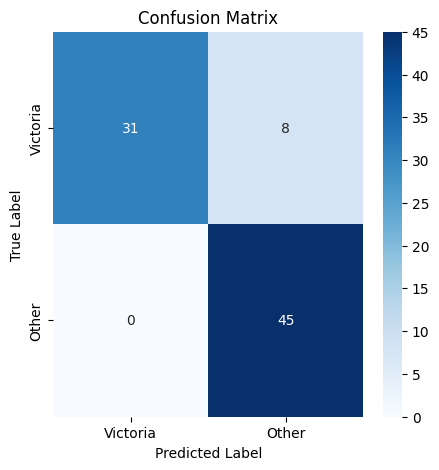

In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Victoria', 'Other'], yticklabels=['Victoria', 'Other'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1. The model correctly classified 76 out of 84 samples (90% accuracy).
2. Perfect recall for "Other" (all actual "Other" samples were correctly classified).
3. Some misclassification for "Victoria" (8 actual "Victoria" samples were wrongly predicted as "Other").
4. The model tends to underpredict Victoria, meaning it sometimes fails to detect them.

# Functional API

In [49]:
inputs = tf.keras.Input(shape=(13,)) # 13 columns

dense1 = Dense(32, activation="relu")(inputs)
dropout1 = Dropout(0.3)(dense1) # to prevent overfitting

# LeakyReLU activation
dense2 = Dense(16, activation=LeakyReLU(alpha=0.2),
               kernel_initializer = tf.keras.initializers.GlorotUniform(),
               bias_initializer = tf.keras.initializers.GlorotUniform())(dropout1)
dropout2 = Dropout(0.3)(dense2)

dense3 = Dense(16, activation="relu")(dropout1)
dropout3 = Dropout(0.3)(dropout1)

cat_layer = tf.keras.layers.Concatenate(axis=1)([dense3,dense2])

#  softmax activation (2 classes: Vic or Other)
out = Dense(2, activation='softmax')(cat_layer)

model = Model(inputs=inputs, outputs=out)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │            448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 16)             │            528 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 16)             │            528 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32)             │              0 │ dense_5[0][0],         │
│                           │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 2)              │             66 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,570 (6.13 KB)

 Trainable params: 1,570 (6.13 KB)

 Non-trainable params: 0 (0.00 B)

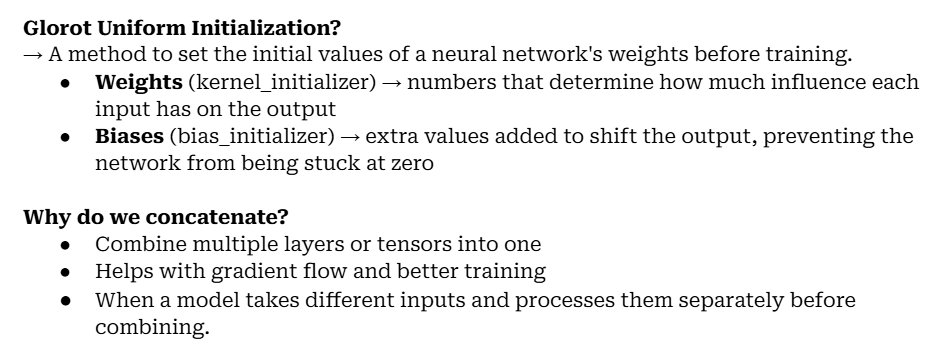

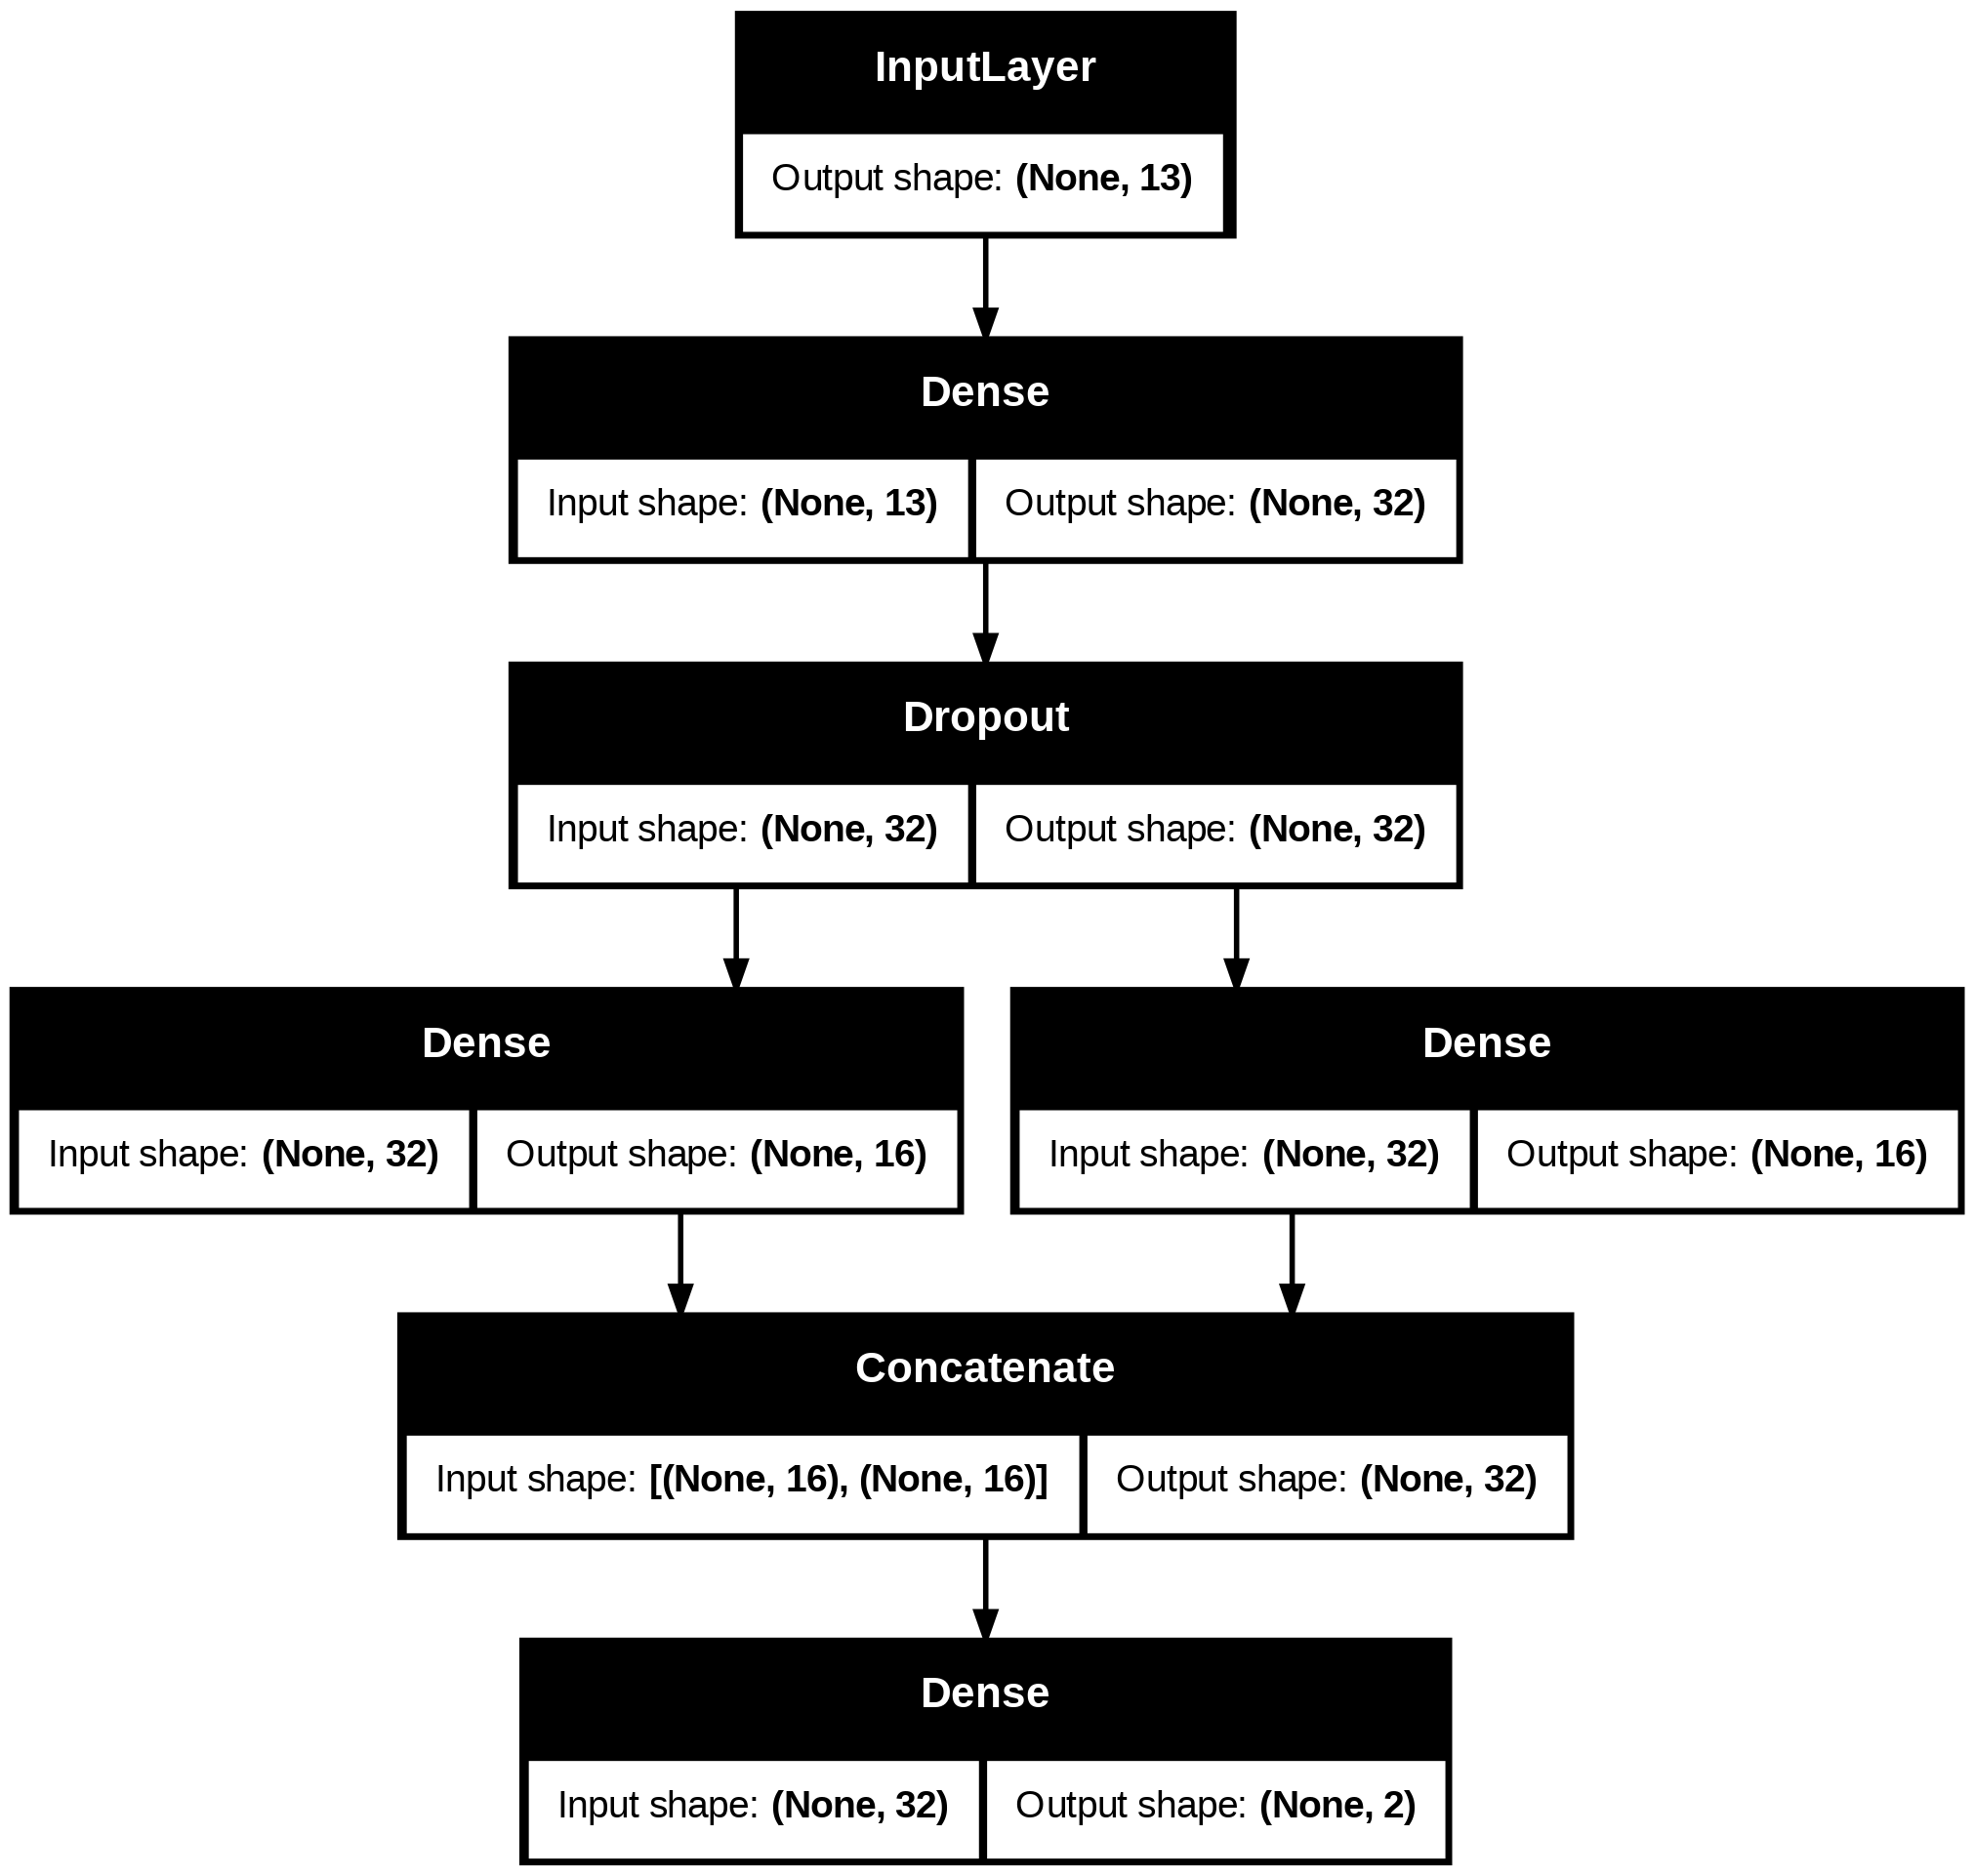

In [50]:
plot_model(model,show_shapes=True)

In [51]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [52]:
history = model.fit(train_ds,validation_data=val_ds,epochs = 50)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4000 - loss: 2.2204 - val_accuracy: 0.2000 - val_loss: 4.0086
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4000 - loss: 1.6947 - val_accuracy: 0.2000 - val_loss: 3.8875
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4000 - loss: 1.6802 - val_accuracy: 0.2000 - val_loss: 3.7681
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4000 - loss: 1.7409 - val_accuracy: 0.2000 - val_loss: 3.6504
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4000 - loss: 2.0783 - val_accuracy: 0.2000 - val_loss: 3.5335
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4000 - loss: 1.9259 - val_accuracy: 0.2000 - val_loss: 3.4176
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4000 - loss: 1.3938 - val_accuracy: 0.2000 - val_loss: 3.3068
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4000 - loss: 1.8463 - val_accuracy: 0.2000 - val_loss: 3.1942
Ep

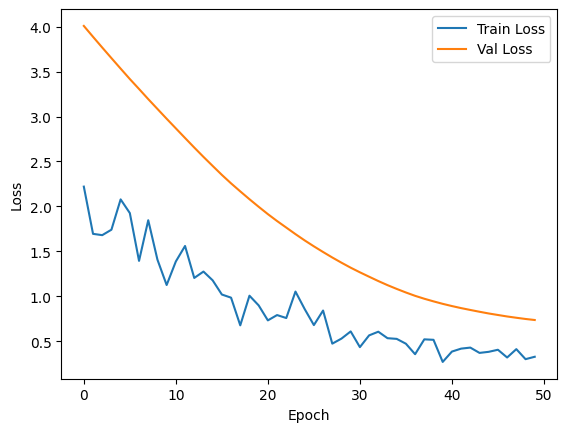

In [53]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [54]:
# test the model
model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9232 - loss: nan 


[nan, 0.9166666865348816]

1. There are 3 batches in the test dataset.
2. The model achieved 92.32% accuracy on the test dataset.
3. The loss value nan indicating there is an issue.

(same with sequentia)

In [60]:
# predict the class probabilities for the training data
train_result_func=model.predict(x_train)

# predicts the class probabilities for the test data
test_result_func=model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [61]:
# convert predicted probabilities to class labels
y_train_pred_func = np.argmax(train_result_func, axis=1)
y_test_pred_func = np.argmax(test_result_func, axis=1)

# convert actual labels from one-hot encoding to class labels
y_train_true_func = np.argmax(y_train.values, axis=1)
y_test_true_func = np.argmax(y_test.values, axis=1)

In [62]:
# compute metrics for train set
print("Train Set Evaluation:")
print(classification_report(y_train_true_func, y_train_pred_func, target_names=['Victoria', 'Other']))
print("\n")
# compute metrics for test set
print("Test Set Evaluation:")
print(classification_report(y_test_true_func, y_test_pred_func, target_names=['Victoria', 'Other']))

Train Set Evaluation:
              precision    recall  f1-score   support

    Victoria       1.00      0.83      0.91         6
       Other       0.90      1.00      0.95         9

    accuracy                           0.93        15
   macro avg       0.95      0.92      0.93        15
weighted avg       0.94      0.93      0.93        15



Test Set Evaluation:
              precision    recall  f1-score   support

    Victoria       0.85      1.00      0.92        39
       Other       1.00      0.84      0.92        45

    accuracy                           0.92        84
   macro avg       0.92      0.92      0.92        84
weighted avg       0.93      0.92      0.92        84



The model generalizes well, but it slightly favors predicting "Victoria" over "Other" in the test set.

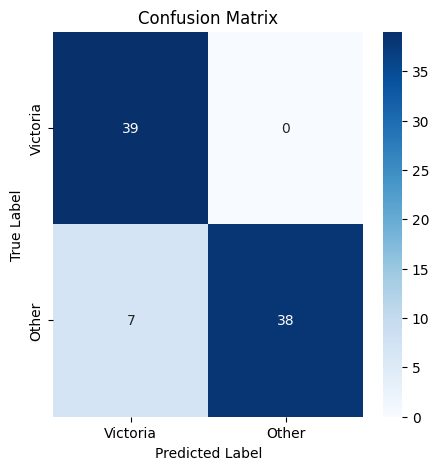

In [64]:
cm1 = confusion_matrix(y_test_true_func, y_test_pred_func)

plt.figure(figsize=(5,5))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=['Victoria', 'Other'], yticklabels=['Victoria', 'Other'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1. The model correctly classified 77 out of 84 samples (92% accuracy).
2. It made 7 mistakes, all from misclassifying "Other" as "Victoria".
3. Perfect recall for "Victoria" (all actual Victoria samples were classified correctly).
4. Some misclassification for "Other" (7 actual "Other" samples were wrongly predicted as "Victoria").

## Sometimes, when I hit a dead neuron, I wish ReLU were as easy to apply as rely on you.

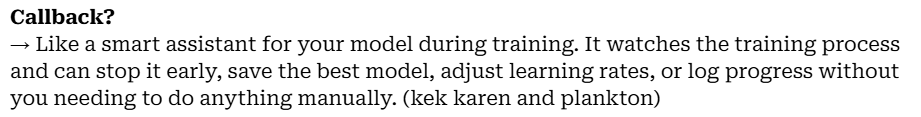

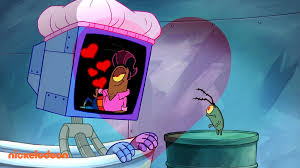